In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [2]:
def read_data(filename='./data/seeds_dataset.txt'):
    """
    Load the dataset from the filepath.
    
    Parameters
    ----------
    filename - string
    
    Returns
    -------
    data - numpy array of floats
    labels - numpy array of integers
    """
    feats = []
    labels = []
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip().replace('\t\t','\t').split('\t')
            f1, f2, f3, f4, f5, f6, f7, label = float(line[0]), float(line[1]), \
                                                float(line[2]), float(line[3]), \
                                                float(line[4]), float(line[5]), \
                                                float(line[6]), int(line[7])
            feats.append([f1, f2, f3, f4, f5, f6, f7])
            labels.append(label)
    return np.array(feats), np.array(labels)


In [3]:
def std_scaler(feats):
    """
    
    """
    f_mean = np.mean(feats, axis=0)
    f_std = np.std(feats, axis=0)
    
    feats_scaled = (feats - f_mean)/f_std
    return feats_scaled


In [4]:
def train_test_split(X, y, test_size=0.2, random_state=21):
    """
    Split the dataset into train and test splits.
    
    Parameters:
    X (numpy.ndarray): Input features array.
    y (numpy.ndarray): Target variable array.
    test_size (float, optional): The proportion of the dataset to include in the test split (default: 0.2).
    random_state (int, optional): Seed value for random number generation (default: 21).
    
    Returns:
    X_train (numpy.ndarray): Training set input features.
    y_train (numpy.ndarray): Training set target variable.
    X_test (numpy.ndarray): Test set input features.
    y_test (numpy.ndarray): Test set target variable.
    """
    
    # Set the seed for reproducibility
    np.random.seed(random_state)
    
    # Shuffle the dataset indices
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    # Calculate the index to split the dataset
    split_index = int((1 - test_size) * X.shape[0])
    
    # Split the dataset into train and test sets
    X_train, X_test = X[indices[:split_index]], X[indices[split_index:]]
    y_train, y_test = y[indices[:split_index]], y[indices[split_index:]]
    
    return X_train, y_train, X_test, y_test

In [5]:
def hierarchical_clustering(X, n_clusters):
    # Calculate the pairwise distance matrix
    pairwise_dist = np.zeros((X.shape[0], X.shape[0]))
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            pairwise_dist[i, j] = np.linalg.norm(X[i] - X[j])

    # Initialize cluster assignments
    cluster_assignments = np.arange(X.shape[0])

    # Perform hierarchical clustering
    for _ in range(X.shape[0] - n_clusters):
        # Find the two closest clusters
        closest_clusters = np.unravel_index(np.argmin(pairwise_dist), pairwise_dist.shape)

        # Merge the closest clusters
        cluster_assignments[cluster_assignments == closest_clusters[1]] = closest_clusters[0]

        # Update the pairwise distance matrix
        pairwise_dist[closest_clusters[0], :] = np.minimum(pairwise_dist[closest_clusters[0], :], pairwise_dist[closest_clusters[1], :])
        pairwise_dist[:, closest_clusters[0]] = pairwise_dist[closest_clusters[0], :]

    return cluster_assignments

distortion is---------- 
[0. 0. 0. 0. 0. 0.]


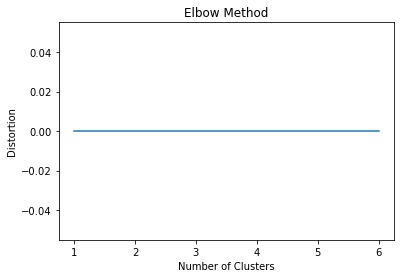

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [6]:
# Load the dataset
feats, labels = read_data()
labels = np.array([0 if i==1 else 1 if i==2 else 2 for i in labels])

X = std_scaler(feats)
y = labels


def determine_clusters(X):
    max_clusters = min(X.shape) - 1
    distortion = np.zeros(max_clusters)

    for k in range(1, max_clusters + 1):
        cluster_assignments = hierarchical_clustering(X, k)
        unique_clusters = np.unique(cluster_assignments)

        if len(unique_clusters) > 1:
            cluster_centers = np.zeros((len(unique_clusters), X.shape[1]))

            for i, cluster_id in enumerate(unique_clusters):
                cluster_centers[i] = np.mean(X[cluster_assignments == cluster_id], axis=0)

            distortion[k - 1] = np.sum(np.linalg.norm(X - cluster_centers[cluster_assignments], axis=1))

    # Plot the distortion vs. number of clusters
    plt.plot(np.arange(1, max_clusters + 1), distortion)
    print(f'distortion is---------- \n{distortion}')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.title('Elbow Method')
    plt.show()

    return cluster_assignments


def assign_labels(X, y, cluster_assignments):
    labels = np.zeros(X.shape[0])

    for cluster_id in np.unique(cluster_assignments):
        cluster_indices = np.where(cluster_assignments == cluster_id)[0]
        cluster_labels = y[cluster_indices]
        unique_labels, label_counts = np.unique(cluster_labels, return_counts=True)
        majority_label = unique_labels[np.argmax(label_counts)]
        labels[cluster_indices] = majority_label

    return labels.astype(int)

# Determine the number of clusters
cluster_assignments = determine_clusters(X)

# Assign labels to the data points based on cluster similarity
predicted_labels = assign_labels(X, y, cluster_assignments)

# Print the predicted labels
print(predicted_labels)


In [11]:
from sklearn.metrics import silhouette_score

def determine_clusters(X):
    max_clusters = min(X.shape) - 1
    silhouette_scores = np.zeros(max_clusters)

    for k in range(2, max_clusters + 1):
        cluster_assignments = hierarchical_clustering(X, k)
        score = silhouette_score(X, cluster_assignments)
        silhouette_scores[k - 1] = score

    # Plot the silhouette scores vs. number of clusters
    plt.plot(np.arange(2, max_clusters + 1), silhouette_scores)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score Method')
    plt.show()

determine_clusters(std_scaler(feats))

ValueError: Number of labels is 210. Valid values are 2 to n_samples - 1 (inclusive)

In [14]:
# Distance function (Euclidean distance)
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

# Clustering function (Hierarchical Clustering)
def hierarchical_clustering(data, num_clusters):
    n = data.shape[0]
    distances = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            distances[i, j] = euclidean_distance(data[i], data[j])

    clusters = [[i] for i in range(n)]

    while len(clusters) > num_clusters:
        min_distance = np.inf
        merge_indices = (0, 0)

        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                cluster1 = clusters[i]
                cluster2 = clusters[j]
                distance = 0

                for c1 in cluster1:
                    for c2 in cluster2:
                        distance += distances[c1, c2]

                distance /= (len(cluster1) * len(cluster2))

                if distance < min_distance:
                    min_distance = distance
                    merge_indices = (i, j)

        merged_cluster = clusters[merge_indices[0]] + clusters[merge_indices[1]]
        del clusters[merge_indices[1]]
        del clusters[merge_indices[0]]
        clusters.append(merged_cluster)

    return clusters


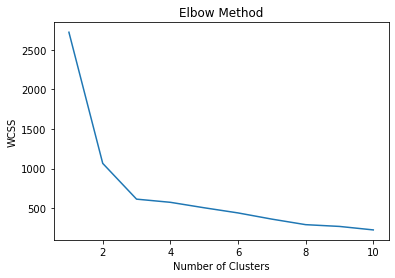

In [16]:
def calculate_wcss(clusters, data):
    wcss = 0
    for cluster in clusters:
        cluster_data = data[cluster]
        centroid = np.mean(cluster_data, axis=0)
        wcss += np.sum((cluster_data - centroid) ** 2)

    return wcss

# Determine optimal number of clusters
max_clusters = 10
wcss_values = []

for num_clusters in range(1, max_clusters + 1):
    clusters = hierarchical_clustering(feats, num_clusters)
    wcss = calculate_wcss(clusters, feats)
    wcss_values.append(wcss)

# Plot the WCSS values
plt.plot(range(1, max_clusters + 1), wcss_values)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()


